In [5]:
import lightning as L
import torchmetrics
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split
from torchvision.datasets import MNIST
from collections import OrderedDict

torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])
train_dataset = MNIST(root="../../data", download=True, transform=transforms.ToTensor(), train=True)
test_dataset = MNIST(root="../../data", transform=transforms.ToTensor(), train=False)

train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])

train_loader = DataLoader(
  dataset=train_dataset,
  batch_size=128,
  shuffle=True,
  num_workers=11,
)

val_loader = DataLoader(
  dataset=val_dataset,
  batch_size=128,
  num_workers=11,
)

test_loader = DataLoader(
  dataset=test_dataset,
  batch_size=128,
  num_workers=0,
)

class MnistClassifierModel(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.seq = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 32, 3, 1)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('relu2', nn.ReLU()),
            ('maxpool', nn.MaxPool2d(2)),
            ('dropout1', nn.Dropout(0.25)),
            ('flatten', nn.Flatten()),
            ('lin1', nn.Linear(9216, 128)),
            ('relu3', nn.ReLU()),
            ('dropout2', nn.Dropout(0.5)),
            ('lin2', nn.Linear(128, 10)),
        ]))

        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)

    def forward(self, x):
        return self.seq(x)

    
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)
        predictions = torch.argmax(logits, dim=1)
        return loss, true_labels, predictions
    
    def training_step(self, batch, batch_idx: int):
        loss, true_labels, predictions = self._shared_step(batch)

        self.log('train_loss', loss)

        # Track accuracy
        self.train_acc(predictions, true_labels)
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=False)

        return loss # this is passed to the optimizer for training
    
    def validation_step(self, batch, batch_idx: int):
        loss, true_labels, predictions = self._shared_step(batch)

        self.log('val_loss', loss, prog_bar=True)

        # Track accuracy
        self.val_acc(predictions, true_labels)
        self.log('val_acc', self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx: int):
        loss, true_labels, predictions = self._shared_step(batch)

        # Track accuracy
        self.test_acc(predictions, true_labels)
        self.log('accuracy', self.test_acc, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters())
        return optimizer


In [6]:
model = MnistClassifierModel().to(device)

trainer = L.Trainer(
  max_epochs=3,
  accelerator='gpu',
  devices='auto' # Use all available GPUs if applicable
)

trainer.fit(
  model,
  train_dataloaders=train_loader,
  val_dataloaders=val_loader
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | seq       | Sequential         | 1.2 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.800     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


<BarContainer object of 10 artists>

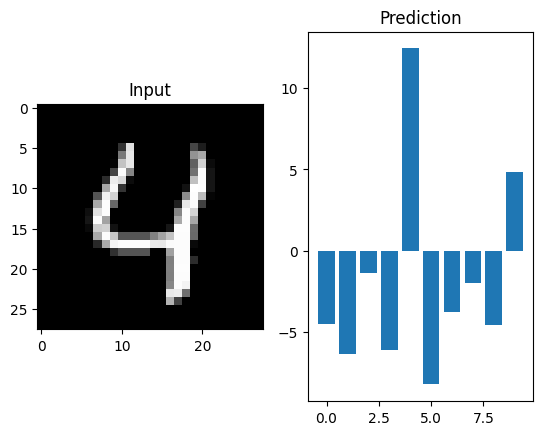

In [7]:
import matplotlib.pyplot as plt

torch.manual_seed(1)

img = test_dataset[0][0][0]

img = next(iter(test_loader))[0][4][0]

plt.subplot(1, 2, 1)
plt.title('Input')
plt.imshow(img, cmap='gray')

img = img.view(1, 1, 28, 28)

model.eval()
# do prediction
prediction = model(img)
plt.subplot(1, 2, 2)
plt.title('Prediction')
plt.bar(range(0, 10), prediction[0].detach().numpy())


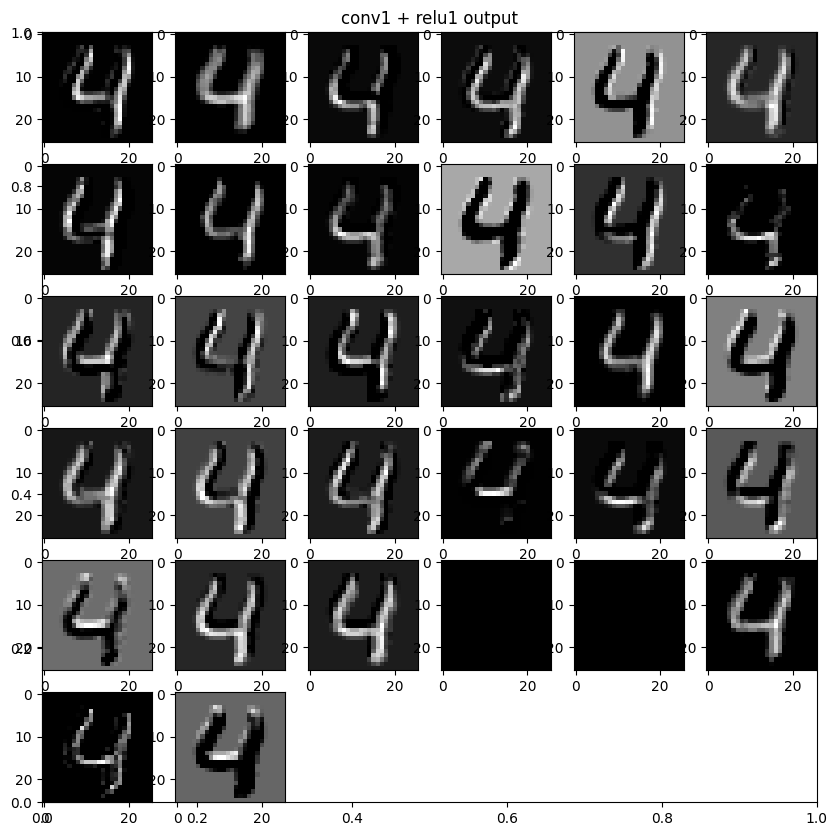

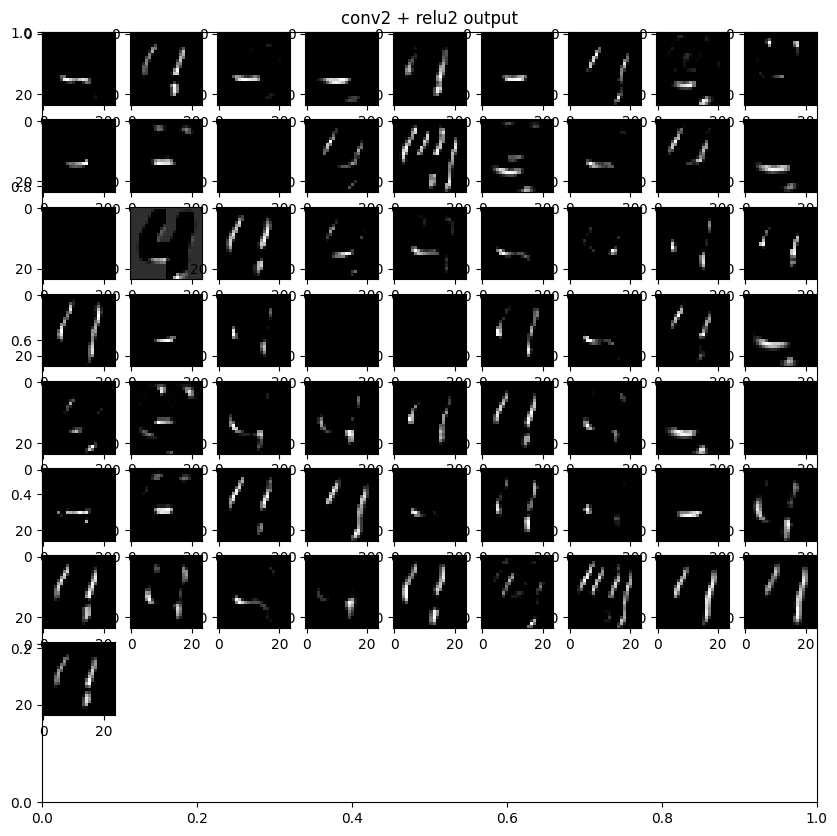

In [8]:
import numpy as np

relu1_ins: list[torch.Tensor] = []
relu1_outs: list[torch.Tensor] = []

@model.get_submodule('seq.relu1').register_forward_hook
def my_hook(module, input, output):
    relu1_ins.append(input[0])
    relu1_outs.append(output)

relu2_ins: list[torch.Tensor] = []
relu2_outs: list[torch.Tensor] = []

@model.get_submodule('seq.relu2').register_forward_hook
def my_hook(module, input, output):
    relu2_ins.append(input[0])
    relu2_outs.append(output)

# do prediction
try:
    model.eval()
    model(test_dataset[4][0][0].view(1, 1, 28, 28))
finally:
    my_hook.remove()

# after first convolution
plt.figure(figsize=(10, 10))
plt.title('conv1 + relu1 output')

num_subplots = relu1_outs[0][0].shape[0]
width = int(np.sqrt(num_subplots)) + 1
for i in range(0, num_subplots):
    plt.subplot(width, width, i + 1)
    plt.imshow(relu1_outs[0][0][i].detach().numpy(), cmap='gray')

# after second convolution
plt.figure(figsize=(10, 10))
plt.title('conv2 + relu2 output')

num_subplots = relu2_outs[0][0].shape[0]
width = int(np.sqrt(num_subplots)) + 1
for i in range(0, num_subplots):
    plt.subplot(width, width, i + 1)
    plt.imshow(relu2_outs[0][0][i].detach().numpy(), cmap='gray')
